In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
from tqdm import tqdm_notebook
from itertools import product, combinations
import lightgbm as lgb
import gc
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from xgboost import plot_importance
%matplotlib inline

In [3]:
datadir = '../data/raw'
item_categories = pd.read_csv(os.path.join(datadir, 'item_categories.csv'))
item = pd.read_csv(os.path.join(datadir, 'items.csv'))
train = pd.read_csv(os.path.join(datadir, 'sales_train_v2.csv'))
shops = pd.read_csv(os.path.join(datadir, 'shops.csv'))
test = pd.read_csv(os.path.join(datadir, 'test.csv'))

In [4]:
all_data = pd.read_csv('../data/processed/all_data.csv')
all_data.drop(['Unnamed: 0'],axis=1,inplace=True)

In [5]:
file = open('../data/processed/lgb_model','rb')
lgb_model = pickle.load(file)
file.close()

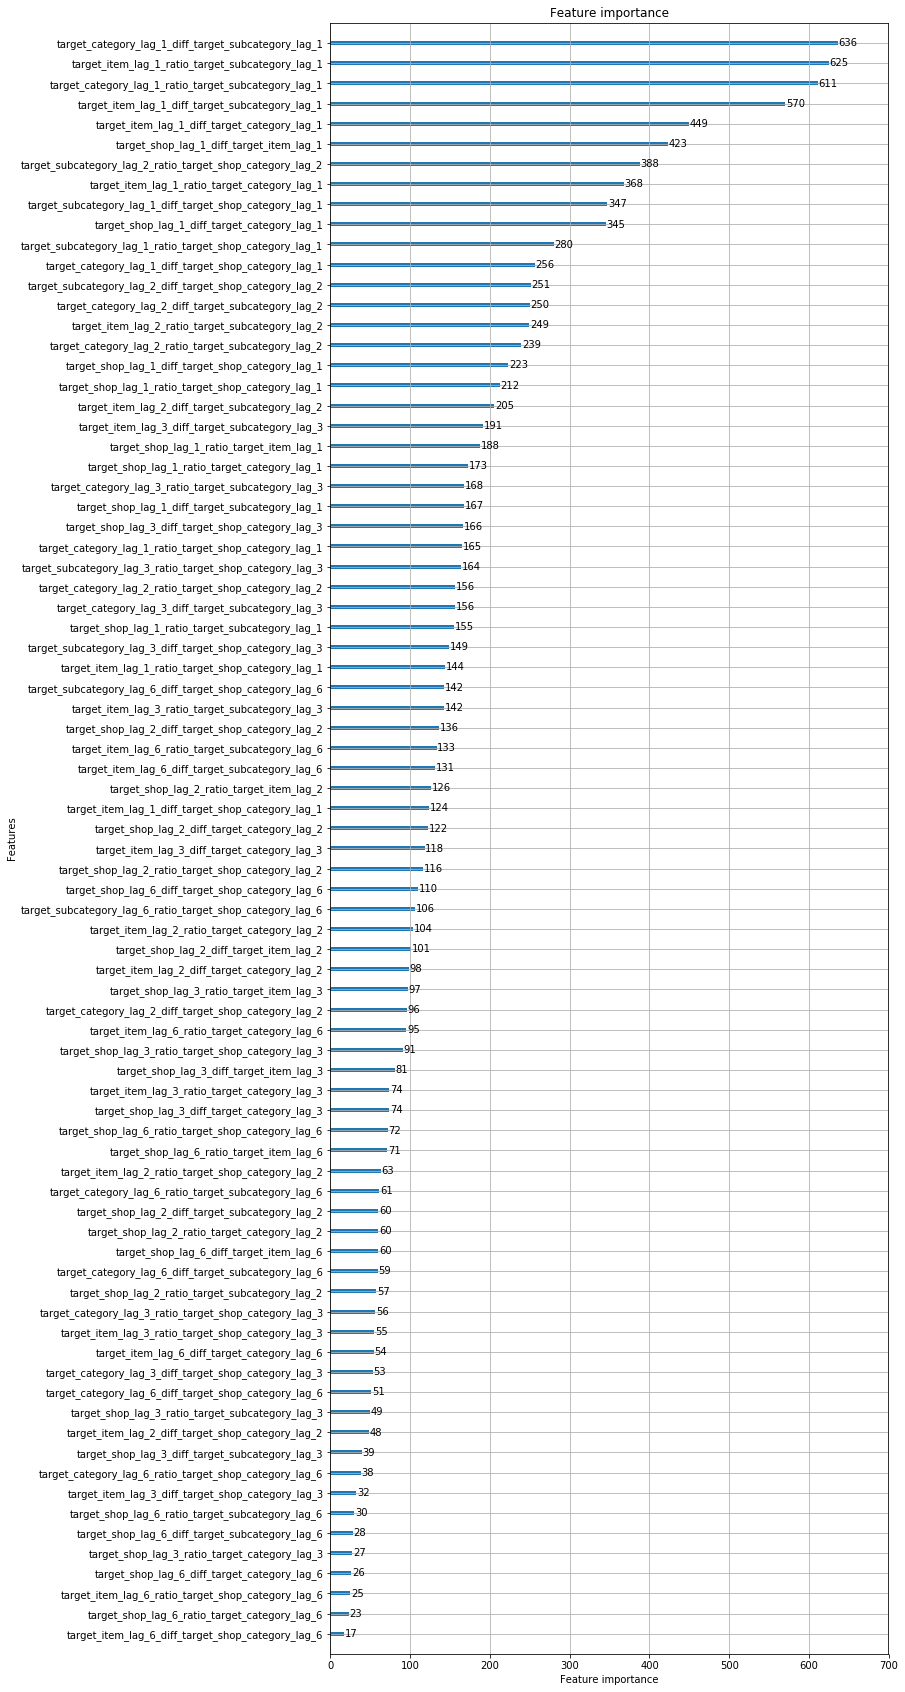

In [6]:
fig = plt.figure(figsize=(10, 14))
ax = lgb.plot_importance(lgb_model, figsize=(10, 30))
plt.show()

### Special features
special features like month number and number of days in the month can help with seasonality

In [7]:
def downcast_type(df):
    float_cols = [c for c in df if df[c].dtype == 'float64']
    int_cols = [c for c in df if df[c].dtype == 'int64']
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    
    return df

In [8]:
# remove data prior to 2013
all_data = all_data[all_data['date_block_num'] >= 12]

In [9]:
all_data = downcast_type(all_data)
gc.collect()

14

In [10]:
all_data['month'] = all_data['date_block_num'] % 12

In [11]:
all_data.head(5)

,shop_id,item_id,date_block_num,city_code,item_category_id,item_category_name,category_type,category_subtype,target,target_shop,...,target_category_lag_3,target_subcategory_lag_3,target_shop_category_lag_3,target_lag_6,target_shop_lag_6,target_item_lag_6,target_category_lag_6,target_subcategory_lag_6,target_shop_category_lag_6,month
506809,55,492,12,28,76,Программы - Для дома и офиса (Цифра),15,33,20.0,4.349057,...,3.120930,5.750000,5.750000,20.0,3.541667,20.0,1.886792,9.666667,9.666667,0
506810,55,504,12,28,31,Игры PC - Цифра,8,63,7.0,4.349057,...,4.364042,3.733333,3.109375,3.0,3.541667,3.0,4.397213,3.540984,3.431035,0
506811,55,508,12,28,31,Игры PC - Цифра,8,63,3.0,4.349057,...,4.364042,3.733333,3.109375,2.0,3.541667,2.0,4.397213,3.540984,3.431035,0
506812,55,515,12,28,31,Игры PC - Цифра,8,63,6.0,4.349057,...,4.364042,3.733333,3.109375,3.0,3.541667,3.0,4.397213,3.540984,3.431035,0
506813,55,539,12,28,78,Программы - Обучающие (Цифра),15,47,2.0,4.349057,...,3.120930,1.571429,1.571429,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0


The most difficult targets are the predictions for new items. to help the model to focus on those, we compute the time that the item has been on the market. we also compute the mean target for new products in every shop or product category. 

In [12]:
first_item_sale = all_data.groupby(['item_id'])['date_block_num'].min()
all_data['elapsed_first_sale'] = all_data['date_block_num']-all_data['item_id'].map(first_item_sale)

In [13]:
last_item_sale = all_data[all_data['target'] > 0].groupby(['item_id'])['date_block_num'].max()
all_data['elapsed_last_sale'] = all_data['date_block_num']-all_data['item_id'].map(last_item_sale)
all_data['elapsed_last_sale'].clip(lower=0, inplace=True)

In [14]:
new_item_sales = all_data[all_data['elapsed_first_sale'] == 0]

In [15]:
# mean target for new items in every shops
mean_target_shop_new = new_item_sales.groupby(['shop_id'])['target'].mean()
all_data['mean_target_shop_newitem'] = all_data['shop_id'].map(mean_target_shop_new)

In [16]:
# mean target for new items in every product category and sub-category
mean_target_cat_new = new_item_sales.groupby(['category_type'])['target'].mean()
all_data['mean_target_cat_newitem'] = all_data['category_type'].map(mean_target_cat_new)

In [17]:
mean_target_subcat_new = new_item_sales.groupby(['category_subtype'])['target'].mean()
all_data['mean_target_subcat_newitem'] = all_data['category_subtype'].map(mean_target_subcat_new)

In [18]:
# mean target for new items in every shop-category and shop-subcategory
mean_target_shopcat_new = new_item_sales.groupby(['shop_id','category_type'], as_index=False)['target'].mean()
mean_target_shopcat_new.rename(columns={'target':'mean_target_shopcat_newitem'}, inplace=True)
all_data = pd.merge(all_data, mean_target_shopcat_new, how='left', on=['shop_id', 'category_type'])

In [19]:
mean_target_shopsubcat_new = new_item_sales.groupby(['shop_id', 'category_subtype'], as_index=False)['target'].mean()
mean_target_shopsubcat_new.rename(columns={'target': 'mean_target_shopsubcat_newitem'}, inplace=True)
all_data = pd.merge(all_data, mean_target_shopsubcat_new, how='left', on=['shop_id', 'category_subtype'])

In [20]:
del mean_target_shop_new
del mean_target_cat_new
del mean_target_shopcat_new

In [21]:
all_data.head(5)

,shop_id,item_id,date_block_num,city_code,item_category_id,item_category_name,category_type,category_subtype,target,target_shop,...,target_subcategory_lag_6,target_shop_category_lag_6,month,elapsed_first_sale,elapsed_last_sale,mean_target_shop_newitem,mean_target_cat_newitem,mean_target_subcat_newitem,mean_target_shopcat_newitem,mean_target_shopsubcat_newitem
0,55,492,12,28,76,Программы - Для дома и офиса (Цифра),15,33,20.0,4.349057,...,9.666667,9.666667,0,0,0.0,0.365098,0.227573,0.047273,0.926316,1.918033
1,55,504,12,28,31,Игры PC - Цифра,8,63,7.0,4.349057,...,3.540984,3.431035,0,0,0.0,0.365098,1.697089,0.127653,2.508265,5.088050
2,55,508,12,28,31,Игры PC - Цифра,8,63,3.0,4.349057,...,3.540984,3.431035,0,0,0.0,0.365098,1.697089,0.127653,2.508265,5.088050
3,55,515,12,28,31,Игры PC - Цифра,8,63,6.0,4.349057,...,3.540984,3.431035,0,0,0.0,0.365098,1.697089,0.127653,2.508265,5.088050
4,55,539,12,28,78,Программы - Обучающие (Цифра),15,47,2.0,4.349057,...,0.000000,0.000000,0,0,0.0,0.365098,0.227573,0.029261,0.926316,1.163265


## Hyper-parameter optimization

In [22]:
train = all_data[all_data['date_block_num'] < 33]
validation = all_data[all_data['date_block_num'] == 33]
test = all_data[all_data['date_block_num'] == 34]

In [23]:
train.columns

Index(['shop_id', 'item_id', 'date_block_num', 'city_code', 'item_category_id',
       'item_category_name', 'category_type', 'category_subtype', 'target',
       'target_shop', 'target_item', 'target_category', 'target_subcategory',
       'target_shop_category', 'target_lag_1', 'target_shop_lag_1',
       'target_item_lag_1', 'target_category_lag_1',
       'target_subcategory_lag_1', 'target_shop_category_lag_1',
       'target_lag_2', 'target_shop_lag_2', 'target_item_lag_2',
       'target_category_lag_2', 'target_subcategory_lag_2',
       'target_shop_category_lag_2', 'target_lag_3', 'target_shop_lag_3',
       'target_item_lag_3', 'target_category_lag_3',
       'target_subcategory_lag_3', 'target_shop_category_lag_3',
       'target_lag_6', 'target_shop_lag_6', 'target_item_lag_6',
       'target_category_lag_6', 'target_subcategory_lag_6',
       'target_shop_category_lag_6', 'month', 'elapsed_first_sale',
       'elapsed_last_sale', 'mean_target_shop_newitem',
       'mean_t

In [24]:
features = ['item_id', 'month', 'elapsed_first_sale', 
            'elapsed_last_sale', 'mean_target_shop_newitem', 'mean_target_cat_newitem', 
            'mean_target_subcat_newitem', 'mean_target_shopcat_newitem', 'mean_target_shopsubcat_newitem']

In [25]:
lag_cols = ['target','target_shop','target_item','target_category', 'target_subcategory','target_shop_category']

In [26]:
for lag_col in lag_cols:
    for lag in [1, 2, 3, 6]:
        features.append('{0}_lag_{1}'.format(lag_col, lag))

In [27]:
features

['item_id',
 'month',
 'elapsed_first_sale',
 'elapsed_last_sale',
 'mean_target_shop_newitem',
 'mean_target_cat_newitem',
 'mean_target_subcat_newitem',
 'mean_target_shopcat_newitem',
 'mean_target_shopsubcat_newitem',
 'target_lag_1',
 'target_lag_2',
 'target_lag_3',
 'target_lag_6',
 'target_shop_lag_1',
 'target_shop_lag_2',
 'target_shop_lag_3',
 'target_shop_lag_6',
 'target_item_lag_1',
 'target_item_lag_2',
 'target_item_lag_3',
 'target_item_lag_6',
 'target_category_lag_1',
 'target_category_lag_2',
 'target_category_lag_3',
 'target_category_lag_6',
 'target_subcategory_lag_1',
 'target_subcategory_lag_2',
 'target_subcategory_lag_3',
 'target_subcategory_lag_6',
 'target_shop_category_lag_1',
 'target_shop_category_lag_2',
 'target_shop_category_lag_3',
 'target_shop_category_lag_6']

In [28]:
X_train = train[features]
y_train = train['target']

X_val = validation[features]
y_val = validation['target']

X_test = test[features]

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(2058899, 33)
(166110, 33)
(214200, 33)


In [29]:
lgb_params = {
    'feature_fraction': 0.75,
    'metric': 'rmse',
    'nthread': 4,
    'min_data_in_leaf': 2**7,
    'bagging_fraction': 0.75,
    'learning_rate': 0.03,
    'objective': 'mse',
    'bagging_seed': 2**7,
    'num_leaves': 2**8,
    'bagging_freq': 1
}

lgb_model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)

In [31]:
# save model
file = open('../data/processed/lgb_trained_model','wb')
s = pickle.dump(lgb_model,file)
file.close()

In [30]:
y_pred_train = lgb_model.predict(X_train)
train_score = np.sqrt(mean_squared_error(y_train, y_pred_train))

In [31]:
lgm_pred_val = lgb_model.predict(X_val)
val_score = np.sqrt(mean_squared_error(y_val, lgm_pred_val))

In [32]:
print('Train score: {0}, val score: {1}'.format(train_score, val_score))

Train score: 0.9724565178904647, val score: 0.9334058392316246


Plot feature importances...


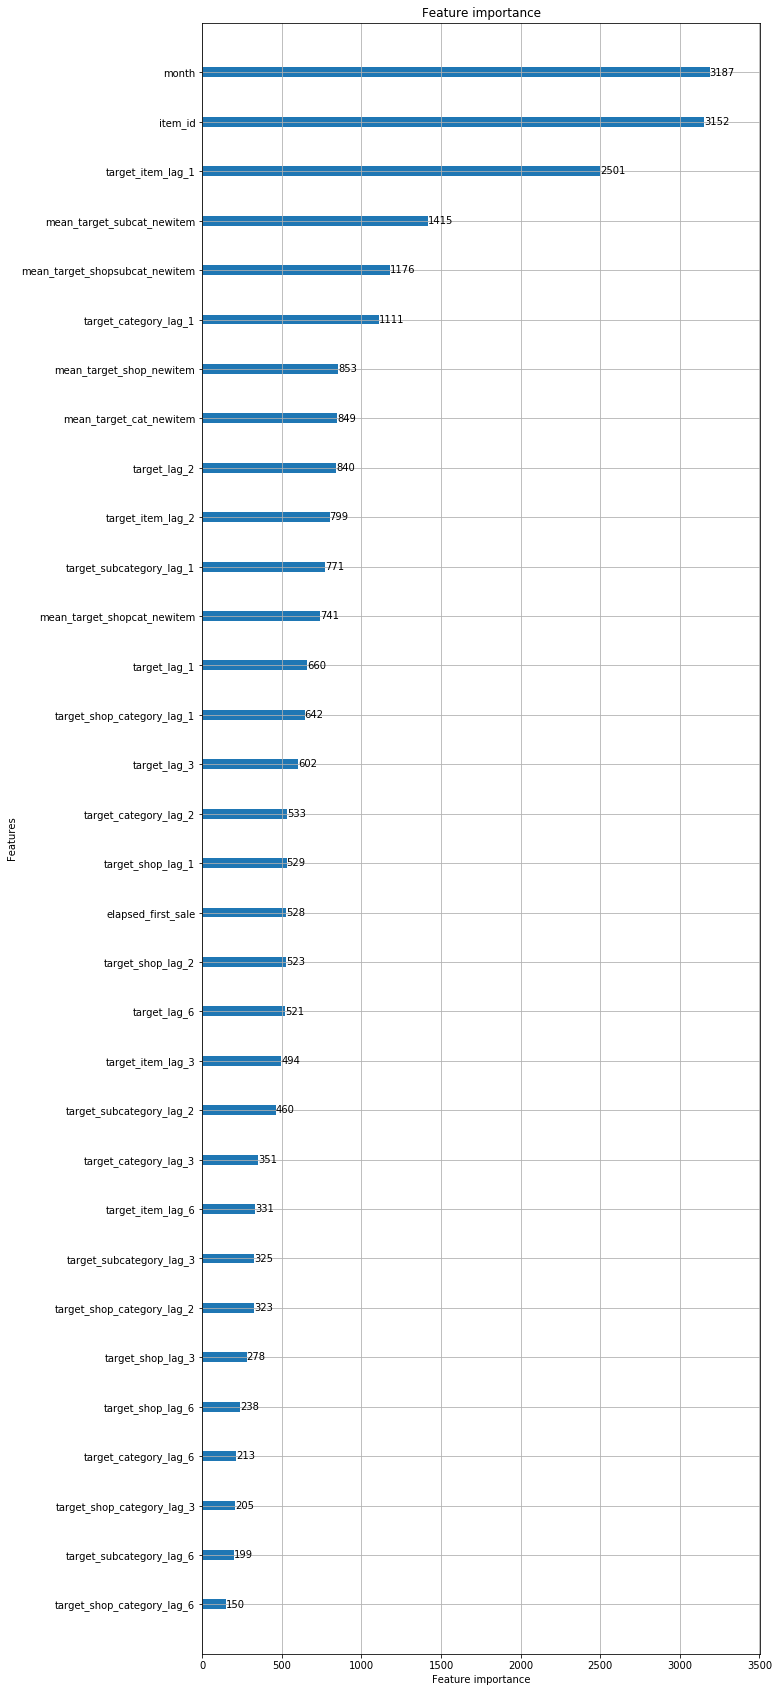

In [33]:
print('Plot feature importances...')
fig = plt.figure(figsize=(10, 30))
ax = lgb.plot_importance(lgb_model, figsize=(10, 30))
plt.show()

Fit data with XGBoost

In [35]:
xgb_params = {'max_depth': 8,
             'n_estimators': 40,
             'min_child_weight': 6, 
             'colsample_bytree': 0.8,
             'subsample': 0.8,
             'eta': 0.3,
             'n_jobs': 4}

xgb_model = XGBRegressor(**xgb_params)

xgb_model.fit(X_train, y_train, eval_metric='rmse', eval_set=[(X_train, y_train), (X_val, y_val)], verbose=True)

[0]	validation_0-rmse:1.50772	validation_1-rmse:1.18368
[1]	validation_0-rmse:1.43844	validation_1-rmse:1.13661
[2]	validation_0-rmse:1.37881	validation_1-rmse:1.09608
[3]	validation_0-rmse:1.33006	validation_1-rmse:1.06576
[4]	validation_0-rmse:1.2853	validation_1-rmse:1.03714
[5]	validation_0-rmse:1.24722	validation_1-rmse:1.01335
[6]	validation_0-rmse:1.2147	validation_1-rmse:0.994373
[7]	validation_0-rmse:1.18884	validation_1-rmse:0.980312
[8]	validation_0-rmse:1.16471	validation_1-rmse:0.967142
[9]	validation_0-rmse:1.14433	validation_1-rmse:0.956999
[10]	validation_0-rmse:1.12627	validation_1-rmse:0.94899
[11]	validation_0-rmse:1.11106	validation_1-rmse:0.941661
[12]	validation_0-rmse:1.09809	validation_1-rmse:0.935929
[13]	validation_0-rmse:1.08672	validation_1-rmse:0.93174
[14]	validation_0-rmse:1.07706	validation_1-rmse:0.928352
[15]	validation_0-rmse:1.06819	validation_1-rmse:0.925828
[16]	validation_0-rmse:1.05859	validation_1-rmse:0.923029
[17]	validation_0-rmse:1.05203	val

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eta=0.3, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=6, missing=None,
       n_estimators=40, n_jobs=4, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8)

In [36]:
y_pred_train = xgb_model.predict(X_train)
train_score = np.sqrt(mean_squared_error(y_train, y_pred_train))

xgb_pred_val = xgb_model.predict(X_val)
val_score = np.sqrt(mean_squared_error(y_val, xgb_pred_val))

print('Train score: {0}, val score: {1}'.format(train_score, val_score))

Train score: 0.986254870891571, val score: 0.9216710925102234


In [37]:
# save model
file = open('../data/processed/xgb_model','wb')
s = pickle.dump(xgb_model,file)
file.close()

In [38]:
xgb_model = pickle.load(open('../data/processed/xgb_model', 'rb'))
xgb_test = xgb_model.predict(X_test)

In [40]:
X_test_level2 = np.c_[xgb_test]

In [41]:
X_test_level2

array([[0.58857894],
       [0.36412477],
       [1.0365722 ],
       ...,
       [0.09194228],
       [0.04558393],
       [0.06257269]], dtype=float32)

In [42]:
xgb_test

array([0.58857894, 0.36412477, 1.0365722 , ..., 0.09194228, 0.04558393,
       0.06257269], dtype=float32)

In [43]:
predictions = pd.DataFrame(X_test_level2)

,0
0,0.588579
1,0.364125
2,1.036572
3,0.296194
4,3.324151
5,0.613096
6,1.110417
7,0.133720
8,0.727445
9,0.710459
